# 🔌 OpenSignals TCP/IP Integration Test

This Colab notebook tests the **TCP/IP streaming interface** of the
[OpenSignals (r)evolution](https://www.pluxbiosignals.com/pages/opensignals) software.

It uses the official `tcp_ip_client_sample.py` code provided by PLUX to connect
to the OpenSignals TCP/IP server and send commands such as `start`, `stop`, and `config`.

You will:
1. Connect to the local OpenSignals TCP/IP server.
2. Send commands interactively.
3. Receive and view real-time data streamed from sensors (e.g., EOG/EEG/ECG).

 **Requirements**
- OpenSignals is running on your computer and TCP/IP is enabled.
- Configured port = 5555 in OpenSignals → *Settings → Integration → TCP-IP*.


In [1]:
#imports and setup
import socket
import json
import threading
import select
import queue
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from matplotlib.animation import FuncAnimation


# Menu of available commands
MENU_INPUT = {
    0: 'devices',
    1: 'config,{MAC|DEVICE_ID}',
    2: 'config,{MAC|DEVICE_ID}, {PARAM}, {VALUE}',
    3: 'enable,{MAC|DEVICE_ID}',
    4: 'disable,{MAC|DEVICE_ID}',
    5: 'start',
    6: 'set_digital_output, {MAC|DEVICE_ID}, {CHANNEL}, {STATE}',
    7: 'stop',
    8: 'exit'
}


Helper Functions for Menu Interaction

In [2]:
def show_menu():
    print("\nAvailable Commands:")
    for id in MENU_INPUT.keys():
        print(f"{id} | {MENU_INPUT[id]}")

def action_decode(action):
    """Convert numeric menu input into the command string OpenSignals expects."""
    if action == '0':
        return 'devices'
    elif action == '1':
        device = input('MAC or DEVICE_ID: ')
        return f'config,{device}'
    elif action == '2':
        device = input('MAC or DEVICE_ID: ')
        param = input('Param (samplingfreq | activechannels): ')
        value = input('Value: ')
        return f'config,{device},{param},{value}'
    elif action == '3':
        device = input('MAC or DEVICE_ID: ')
        return f'enable,{device}'
    elif action == '4':
        device = input('MAC or DEVICE_ID: ')
        return f'disable,{device}'
    elif action == '5':
        return 'start'
    elif action == '6':
        device = input('MAC or DEVICE_ID: ')
        channel = input('Digital output channel number: ')
        state = input('Enable (1) or disable (0)?: ')
        return f'set_digital_output_channel,{device},{channel},{state}'
    elif action == '7':
        return 'stop'
    elif action == '8':
        return ''
    else:
        return ''


TCP Client Class

In [3]:
class TCPClient:
    """
    Handles the socket connection with the OpenSignals TCP/IP server.
    """

    def __init__(self, ip='127.0.0.1', port=5555):
        self.tcpIp = ip
        self.tcpPort = port
        self.buffer_size = 99999

        # Socket and I/O control
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.inputCheck = []
        self.outputCheck = []
        self.isChecking = False
        self.isAcquiring = False
        self.msgQueue = queue.Queue()

        self.txtFile = SaveAcquisition()

    def connect(self):
        """Connect to the OpenSignals TCP/IP server."""
        print(f"Connecting to {self.tcpIp}:{self.tcpPort} ...")
        self.socket.connect((self.tcpIp, self.tcpPort))
        print("Connected!")
        self.outputCheck.append(self.socket)
        self.isChecking = True

    def start(self):
        """Start background thread to check incoming/outgoing messages."""
        thread = threading.Thread(target=self.msgChecker)
        thread.daemon = True
        thread.start()

    def stop(self):
        """Stop the background thread and close socket."""
        self.isChecking = False
        self.socket.close()
        print("Connection closed.")

    def msgChecker(self):
        """Continuously check for messages from OpenSignals."""
        while self.isChecking:
            readable, writable, exceptional = select.select(self.inputCheck, self.outputCheck, self.inputCheck)
            for s in readable:
                message = s.recv(self.buffer_size)
                if not self.isAcquiring:
                    print("Received (status):", message)
                    self.inputCheck = []
                else:
                    try:
                        message = json.loads(message)
                        message = message["returnData"]
                        try:
                            samples = message["returnData"]["data"]
                            if len(samples) > 0:
                                # Each sample frame may have multiple channels; take first channel only
                                sample_val = samples[0][0] if isinstance(samples[0], list) else samples[0]
                                plotter.update(sample_val)
                        except Exception as e:
                            print("Plot update error:", e)
                    except Exception as e:
                        print("Error decoding:", e)

            for s in writable:
                try:
                    next_msg = self.msgQueue.get_nowait()
                except queue.Empty:
                    continue
                else:
                    s.send(str(next_msg).encode())

            for s in exceptional:
                print("Socket exception:", s)

    def addMsgToSend(self, data):
        """Queue a command message to send to OpenSignals."""
        self.msgQueue.put(data)
        if self.socket not in self.outputCheck:
            self.outputCheck.append(self.socket)
        if self.socket not in self.inputCheck:
            self.inputCheck.append(self.socket)

    def setIsAcquiring(self, isAcquiring):
        """Set whether we are acquiring data."""
        self.isAcquiring = isAcquiring
        if self.isAcquiring:
            self.txtFile = SaveAcquisition()
            self.txtFile.start()
        else:
            self.txtFile.stop()


SaveAcquisition Helper Class

In [4]:
class SaveAcquisition:
    """
    Minimal stub for handling data saving during acquisition.
    (Currently only prints and tracks whether a header has been written.)
    """

    def __init__(self):
        self.fileTxt = None
        self.hasHeader = False

    def start(self):
        print("Acquisition started (file writer would start here).")

    def addData(self, data):
        self.hasHeader = True
        # Placeholder: you could write to file here
        print("Data:", data[:100], "..." if len(data) > 100 else "")

    def stop(self):
        print("Acquisition stopped.")

    def getHasHeader(self):
        return self.hasHeader


In [5]:
class LivePlot:
    def __init__(self, window_size=1000, sampling_rate=1000):
        self.window_size = window_size
        self.sampling_rate = sampling_rate
        self.data = deque([0]*window_size, maxlen=window_size)

        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot(range(window_size), list(self.data))
        self.ax.set_ylim(-1024, 1024)  # adjust depending on your signal amplitude
        self.ax.set_title("Live Signal")
        self.ax.set_xlabel("Samples")
        self.ax.set_ylabel("Amplitude")

        plt.ion()
        plt.show(block=False)

    def update(self, new_sample):
        """Append new value and update the plot."""
        self.data.append(new_sample)
        self.line.set_ydata(self.data)
        self.ax.draw_artist(self.ax.patch)
        self.ax.draw_artist(self.line)
        self.fig.canvas.flush_events()


# Set your IP and Port (match OpenSignals Integration settings)


Connecting to 127.0.0.1:5555 ...
Connected!


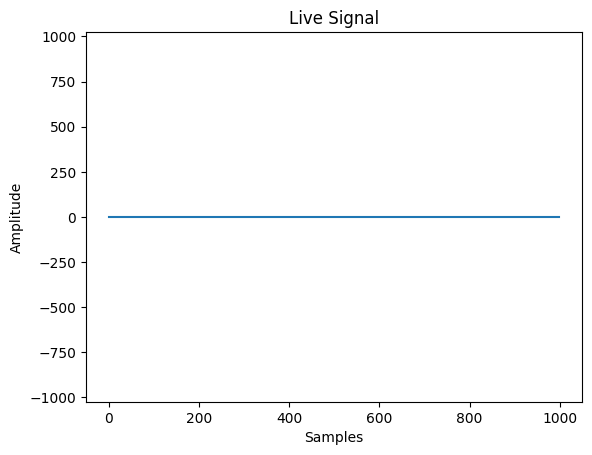


Available Commands:
0 | devices
1 | config,{MAC|DEVICE_ID}
2 | config,{MAC|DEVICE_ID}, {PARAM}, {VALUE}
3 | enable,{MAC|DEVICE_ID}
4 | disable,{MAC|DEVICE_ID}
5 | start
6 | set_digital_output, {MAC|DEVICE_ID}, {CHANNEL}, {STATE}
7 | stop
8 | exit

Available Commands:
0 | devices
1 | config,{MAC|DEVICE_ID}
2 | config,{MAC|DEVICE_ID}, {PARAM}, {VALUE}
3 | enable,{MAC|DEVICE_ID}
4 | disable,{MAC|DEVICE_ID}
5 | start
6 | set_digital_output, {MAC|DEVICE_ID}, {CHANNEL}, {STATE}
7 | stop
8 | exit

Available Commands:
0 | devices
1 | config,{MAC|DEVICE_ID}
2 | config,{MAC|DEVICE_ID}, {PARAM}, {VALUE}
3 | enable,{MAC|DEVICE_ID}
4 | disable,{MAC|DEVICE_ID}
5 | start
6 | set_digital_output, {MAC|DEVICE_ID}, {CHANNEL}, {STATE}
7 | stop
8 | exit

Available Commands:
0 | devices
1 | config,{MAC|DEVICE_ID}
2 | config,{MAC|DEVICE_ID}, {PARAM}, {VALUE}
3 | enable,{MAC|DEVICE_ID}
4 | disable,{MAC|DEVICE_ID}
5 | start
6 | set_digital_output, {MAC|DEVICE_ID}, {CHANNEL}, {STATE}
7 | stop
8 | exit

Availab

In [6]:
client = TCPClient(ip='127.0.0.1', port=5555)
client.connect()
plotter = LivePlot(window_size=1000, sampling_rate=1000)
client.start()

while True:
    show_menu()
    user_action = input("Select action: ")
    if user_action == '5':
        client.setIsAcquiring(True)
    elif user_action == '7':
        client.setIsAcquiring(False)
    elif user_action == '8':
        client.stop()
        break
    msg = action_decode(user_action)
    client.addMsgToSend(msg)